# Business Objective:
## Predict the apple stock market price for next 30 days. There are Open, High, Low and Close price has been given for each day starting from 2012 to 2019 for Apple stock.

### Dataset: AAPL.csv

In [6]:
# Importing libraries

import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import quarter_plot,month_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import date
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import warnings
warnings.filterwarnings('ignore')
from plotly import graph_objs as go

In [7]:
# Reading data
data = pd.read_csv('AAPL.csv')
data 

Date        Open        High         Low       Close   Adj Close  \
0     2012-01-03   58.485714   58.928570   58.428570   58.747143   50.765709   
1     2012-01-04   58.571430   59.240002   58.468571   59.062859   51.038536   
2     2012-01-05   59.278572   59.792858   58.952858   59.718571   51.605175   
3     2012-01-06   59.967144   60.392857   59.888573   60.342857   52.144630   
4     2012-01-09   60.785713   61.107143   60.192856   60.247143   52.061932   
...          ...         ...         ...         ...         ...         ...   
2006  2019-12-23  280.529999  284.250000  280.369995  284.000000  282.054138   
2007  2019-12-24  284.690002  284.890015  282.920013  284.269989  282.322266   
2008  2019-12-26  284.820007  289.980011  284.700012  289.910004  287.923645   
2009  2019-12-27  291.119995  293.970001  288.119995  289.799988  287.814392   
2010  2019-12-30  289.459991  292.690002  285.220001  291.519989  289.522614   

        Volume  
0     75555200  
1     65005500  
2     67817400  
3     79573200  
4     98506100  
...        ...  
2006  24643000  
2007  12119700  
2008  23280300  
2009  36566500  
2010  36028600  

[2011 rows x 7 columns]

## Data Preprocessing

In [8]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [9]:
#Transform Date to datetime object and Set as Index :
data.Date = pd.to_datetime(data.Date)
data.dtypes 

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [10]:
data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

In [11]:
df = data.copy()
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
1 2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2 2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
3 2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
4 2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

In [12]:
df.set_index('Date',inplace=True) 

In [13]:
df.index 

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=2011, freq=None)

In [14]:
df.head() 

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2012-01-03  58.485714  58.928570  58.428570  58.747143  50.765709  75555200
2012-01-04  58.571430  59.240002  58.468571  59.062859  51.038536  65005500
2012-01-05  59.278572  59.792858  58.952858  59.718571  51.605175  67817400
2012-01-06  59.967144  60.392857  59.888573  60.342857  52.144630  79573200
2012-01-09  60.785713  61.107143  60.192856  60.247143  52.061932  98506100

### Check for Holidays :

In [15]:
data.head(1).index, data.tail(1).index 

(RangeIndex(start=0, stop=1, step=1),
 RangeIndex(start=2010, stop=2011, step=1))

In [16]:
d0 = date(2012,1,3)
d1 = date(2019,12,30)
days = len(pd.date_range((d0),(d1)))
print(f'The number of days from {d0} to {d1} is {days} days')
print()
bdays = len(pd.bdate_range((d0),(d1)))
print(f'The number of business days from {d0} to {d1} is {bdays} days')
print()
print(f'The number of days from {d0} to {d1} in the given time series is {len(data)} days') 

The number of days from 2012-01-03 to 2019-12-30 is 2919 days

The number of business days from 2012-01-03 to 2019-12-30 is 2085 days

The number of days from 2012-01-03 to 2019-12-30 in the given time series is 2011 days


### So the time series contains holidays other than weekends.

In [17]:
# Creating CustomBusinessDay :

us_cal = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [18]:
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=us_cal)
print(my_range.difference(df.index))

DatetimeIndex(['2012-04-06', '2012-10-29', '2012-10-30', '2013-03-29',
               '2014-04-18', '2015-04-03', '2016-03-25', '2017-04-14',
               '2018-03-30', '2018-12-05', '2019-04-19'],
              dtype='datetime64[ns]', freq=None)


In [19]:
Cu = CustomBusinessDay(calendar=USFederalHolidayCalendar(),holidays=['2012-04-06', '2012-10-29', '2012-10-30', 
                                                                    '2013-03-29','2014-04-18', '2015-04-03', 
                                                                    '2016-03-25', '2017-04-14', '2018-03-30', 
                                                                    '2018-12-05', '2019-04-19'])
my_range = pd.date_range(start='2012-01-03',end='2019-12-30',freq=Cu)
print(my_range.difference(df.index))

DatetimeIndex([], dtype='datetime64[ns]', freq=None)


#### C is the custom frequency here that includes the holidays other than weekends.

In [20]:
df

Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03   58.485714   58.928570   58.428570   58.747143   50.765709   
2012-01-04   58.571430   59.240002   58.468571   59.062859   51.038536   
2012-01-05   59.278572   59.792858   58.952858   59.718571   51.605175   
2012-01-06   59.967144   60.392857   59.888573   60.342857   52.144630   
2012-01-09   60.785713   61.107143   60.192856   60.247143   52.061932   
...                ...         ...         ...         ...         ...   
2019-12-23  280.529999  284.250000  280.369995  284.000000  282.054138   
2019-12-24  284.690002  284.890015  282.920013  284.269989  282.322266   
2019-12-26  284.820007  289.980011  284.700012  289.910004  287.923645   
2019-12-27  291.119995  293.970001  288.119995  289.799988  287.814392   
2019-12-30  289.459991  292.690002  285.220001  291.519989  289.522614   

              Volume  
Date                  
2012-01-03  75555200  
2012-01-04  65005500  
2012-01-05  67817400  
2012-01-06  79573200  
2012-01-09  98506100  
...              ...  
2019-12-23  24643000  
2019-12-24  12119700  
2019-12-26  23280300  
2019-12-27  36566500  
2019-12-30  36028600  

[2011 rows x 6 columns]

In [21]:
df = df.asfreq(Cu)

In [22]:
df.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19',
               '2019-12-20', '2019-12-23', '2019-12-24', '2019-12-26',
               '2019-12-27', '2019-12-30'],
              dtype='datetime64[ns]', name='Date', length=1995, freq='C')

#### Now the datetime index has the frequncy C.

## Exploratory Data Analysis :

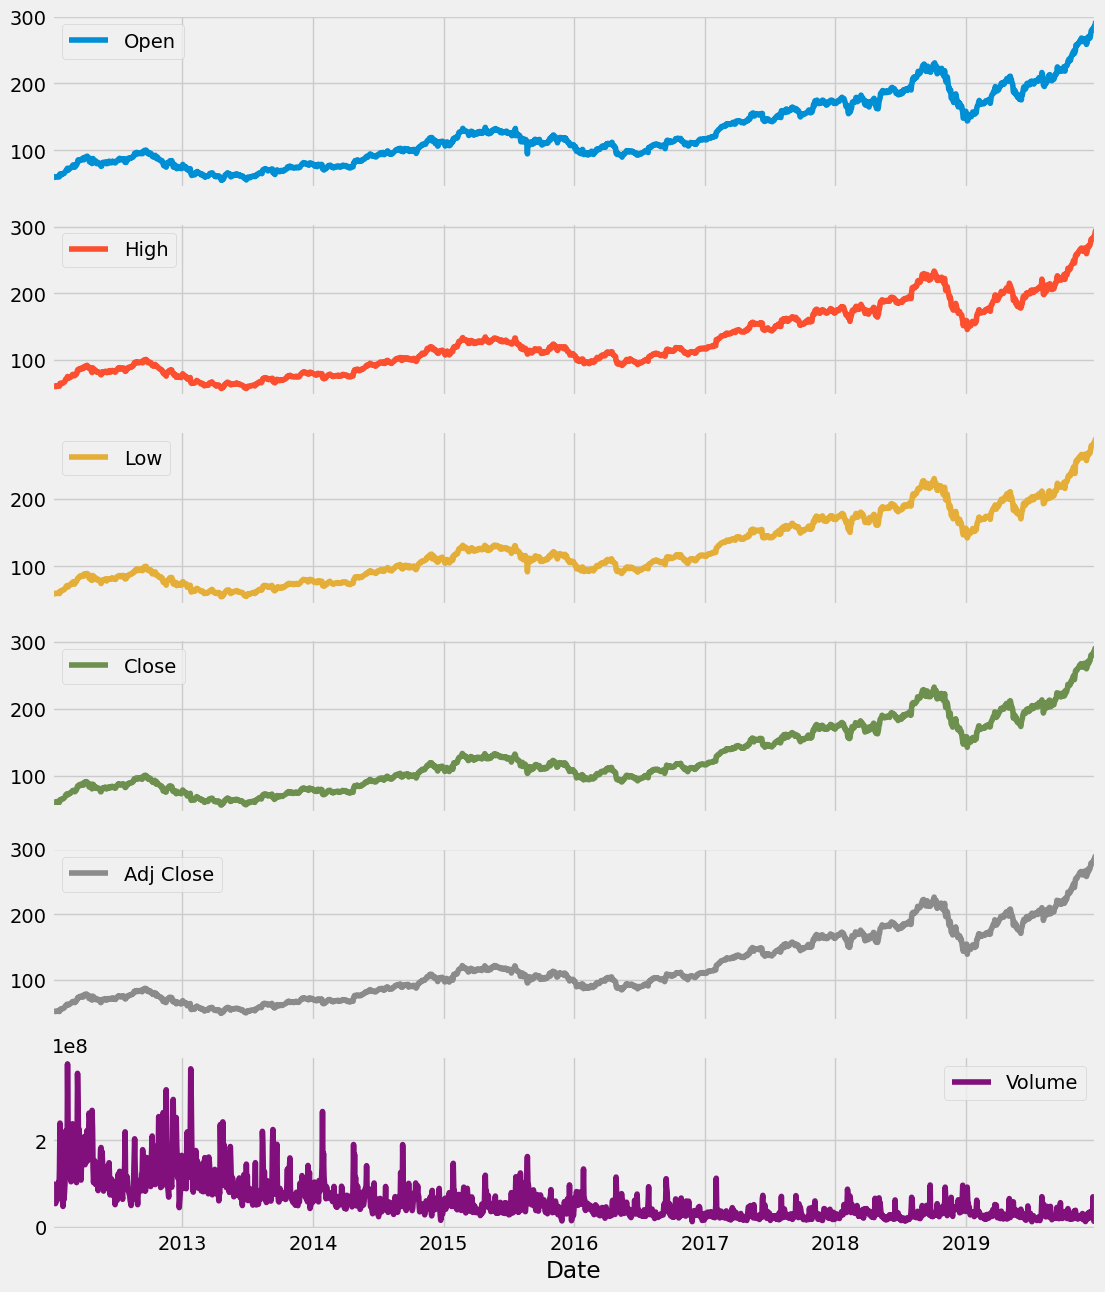

In [23]:
# Lineplot

plt.style.use('fivethirtyeight')
df.plot(subplots=True, figsize=(12,15))
plt.show();

### As there are quite similar values in open, high, low, close, and adj close columns, the line plot of these columns is also similar, we can see that there is an upward trend present .

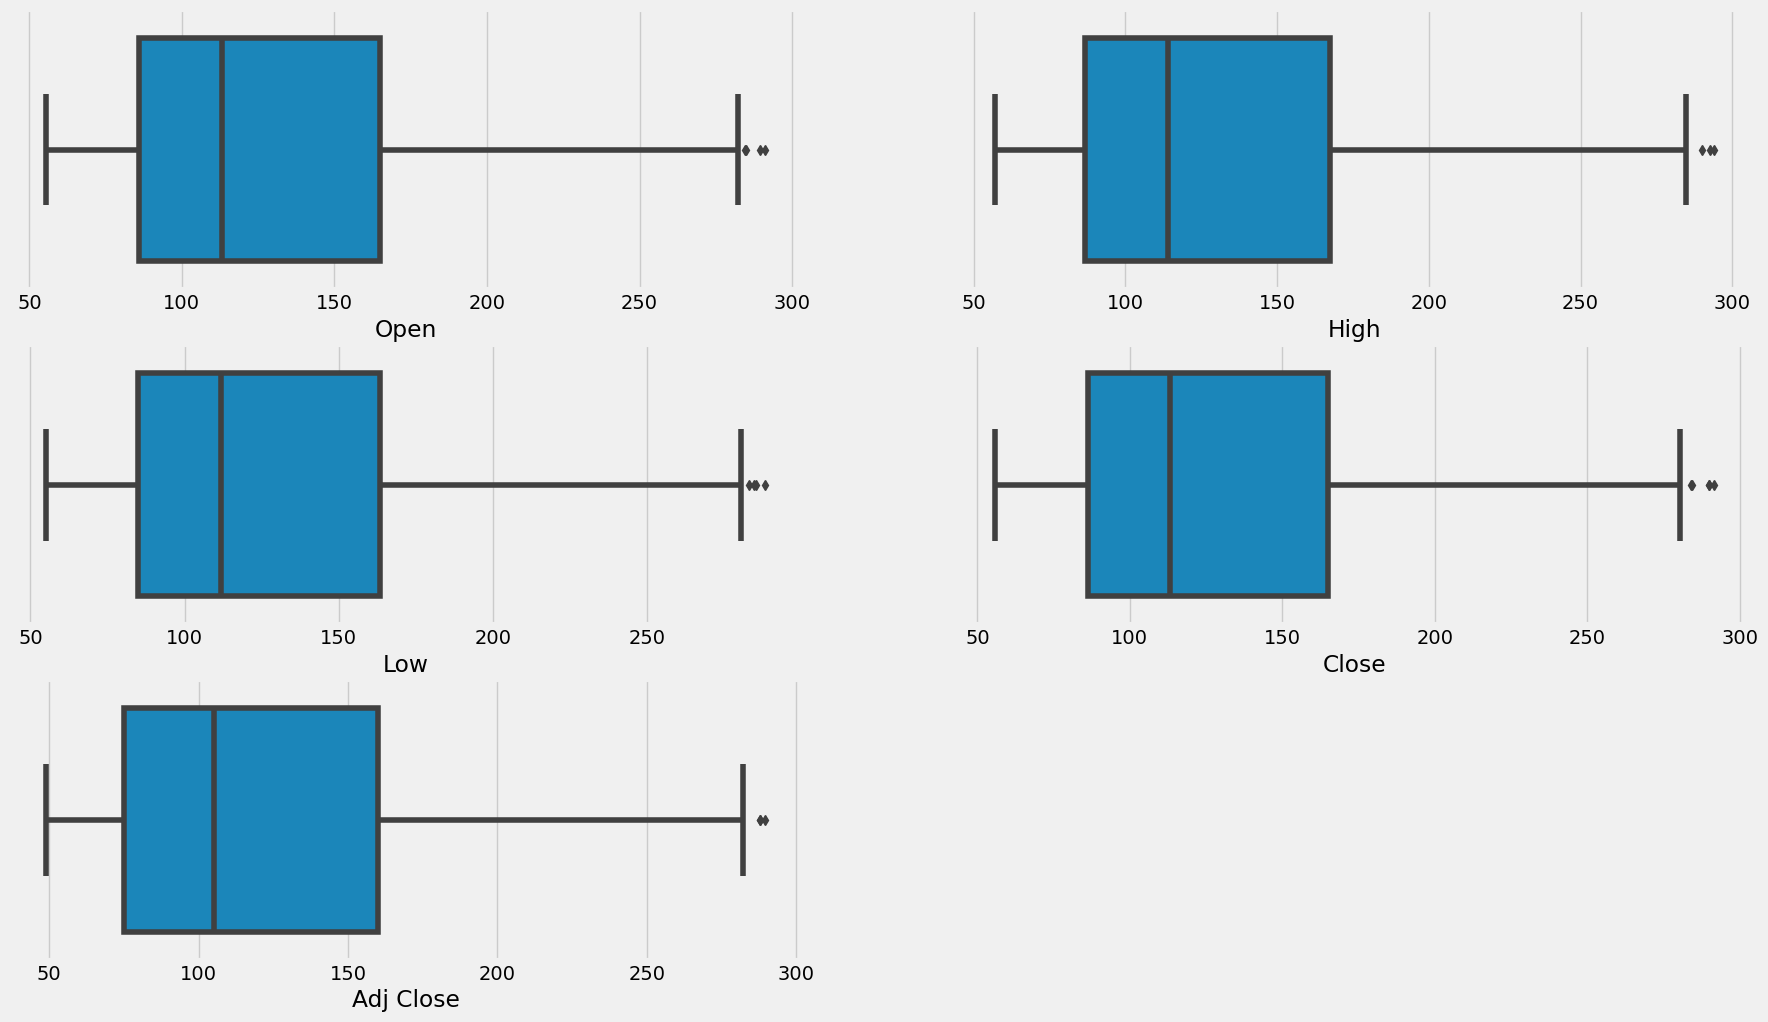

In [24]:
# boxplot: to check outliers

col_names = df.columns

fig = plt.figure(figsize=(20, 20))
for i in range(5):
    plt.subplot(5,2,i+1)
    sns.boxplot(df.iloc[:,i])
   
plt.show()  

### From above boxplot we can say that their are outliers towards higher end around stock price 300 in the data.

In [25]:
# Analysis of relationship between variables

corr = df.corr()
corr

Open      High       Low     Close  Adj Close    Volume
Open       1.000000  0.999781  0.999718  0.999495   0.998892 -0.558429
High       0.999781  1.000000  0.999655  0.999747   0.999167 -0.555355
Low        0.999718  0.999655  1.000000  0.999767   0.999175 -0.563900
Close      0.999495  0.999747  0.999767  1.000000   0.999399 -0.560097
Adj Close  0.998892  0.999167  0.999175  0.999399   1.000000 -0.566760
Volume    -0.558429 -0.555355 -0.563900 -0.560097  -0.566760  1.000000

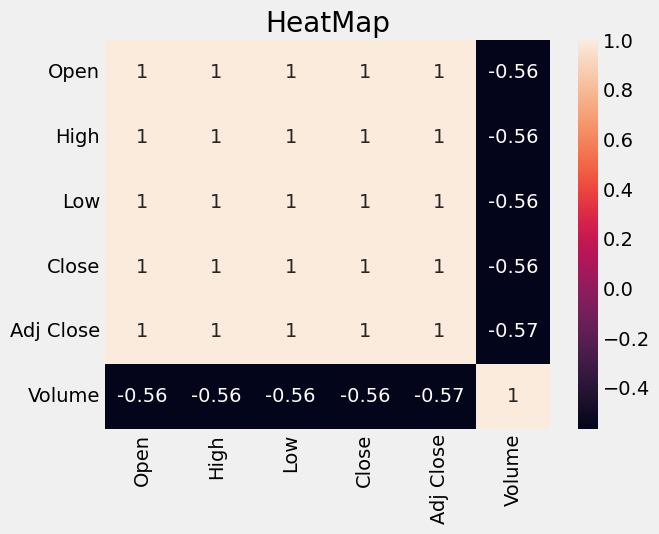

In [26]:
# heatmap

sns.heatmap(corr , annot=True,)
plt.title('HeatMap')
plt.show()

### We can eliminate features like Open,Low, High, Adj Close as they are highly multicollinear with Close.
### So we can consider Close as our target variable.(Because A stock’s closing price is the standard benchmark used by investors to track its performance over time)

In [27]:
# Considering only the closing price for the analysis :
df.drop(['Open','High','Low','Adj Close','Volume'],axis=1,inplace=True)
df.head()

Close
Date                 
2012-01-03  58.747143
2012-01-04  59.062859
2012-01-05  59.718571
2012-01-06  60.342857
2012-01-09  60.247143

### Downsampling the data to Monthly :
To reduce the granularity in the data.

In [28]:
df_m = df.resample('M').mean()
df_m.head(),df_m.tail() 

(                Close
 Date                 
 2012-01-31  61.225428
 2012-02-29  71.081572
 2012-03-31  82.501104
 2012-04-30  86.571857
 2012-05-31  80.667597,
                  Close
 Date                  
 2019-08-31  204.957728
 2019-09-30  217.994999
 2019-10-31  235.260000
 2019-11-30  262.537371
 2019-12-31  275.669496)

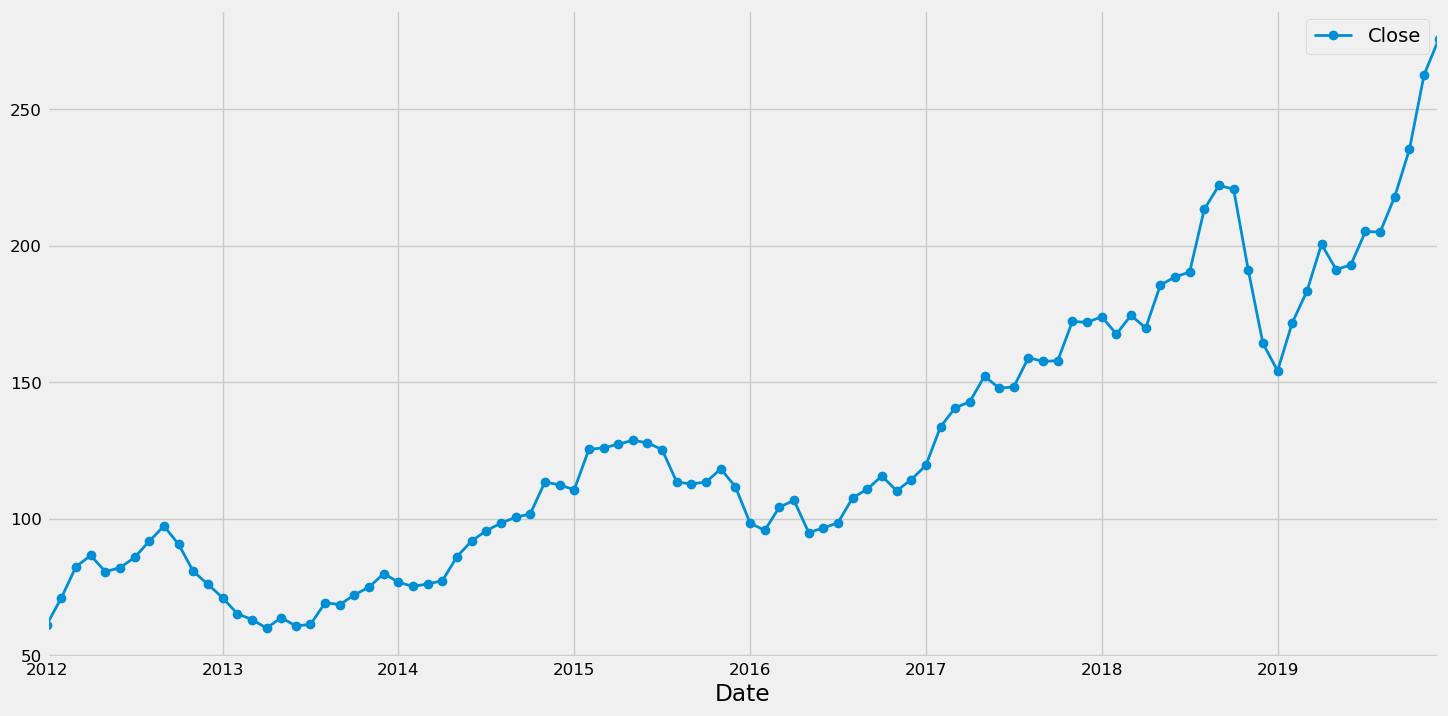

In [29]:
# Lineplot
df_m.plot(figsize=(16,8), linewidth=2,marker='o', fontsize=12);

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_m.index,y=df_m.Close,name='stock_close'))
fig.layout.update(title_text='Line graph of Close price using Plotly with a slider',xaxis_rangeslider_visible=True)
fig.show() 

#### From the above line plot, the mean is not constant and the variance is also not constant. So the series is not stationary.

### Seasonal-Trend Decomposition using LOESS (STL) :

In [31]:
stl = STL(df_m)
result = stl.fit() 

In [32]:
seasonal, trend, resid = result.seasonal, result.trend, result.resid

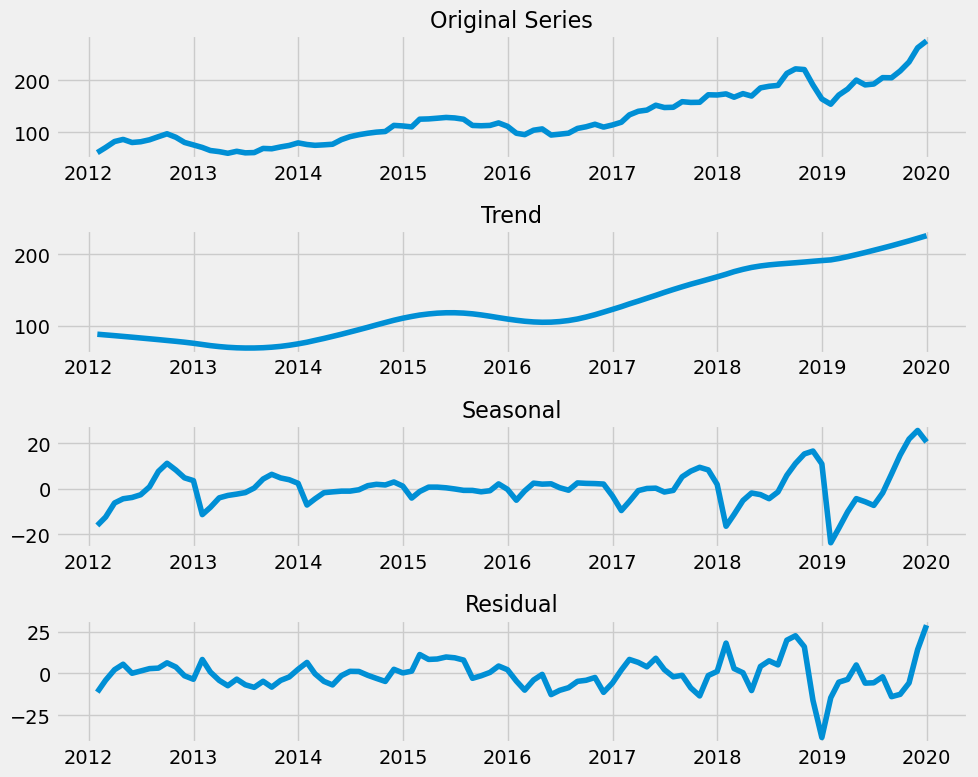

In [33]:
plt.figure(figsize=(10,8))

plt.subplot(4,1,1)
plt.plot(df_m)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout() 

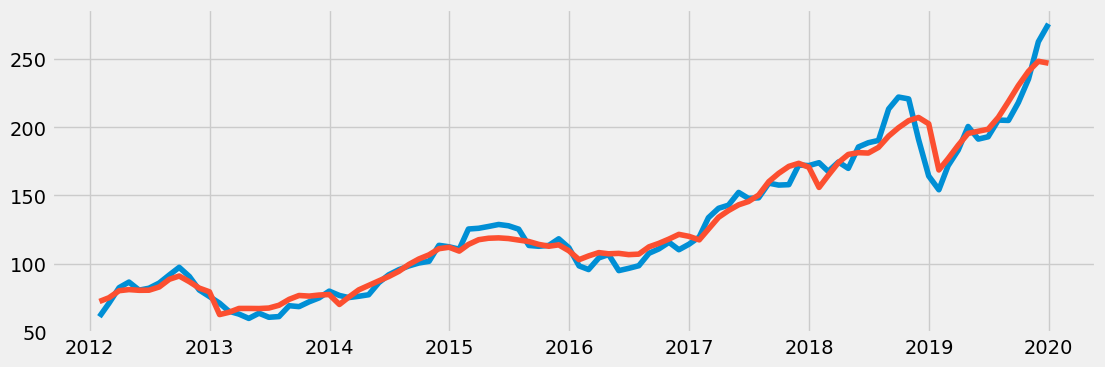

In [34]:
estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(df_m)
plt.plot(estimated);

In [35]:
resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

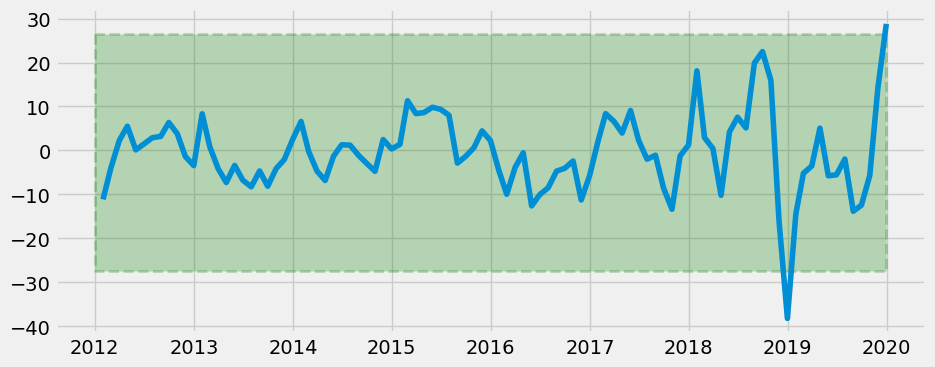

In [36]:
plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2012,1,3), datetime(2019,12,30)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2); 

#### There is anomaly in the months of December of 2018 and 2019 on the lower and upper side.

## Check for Seasonality :

### Seasonal Decomposition plot :

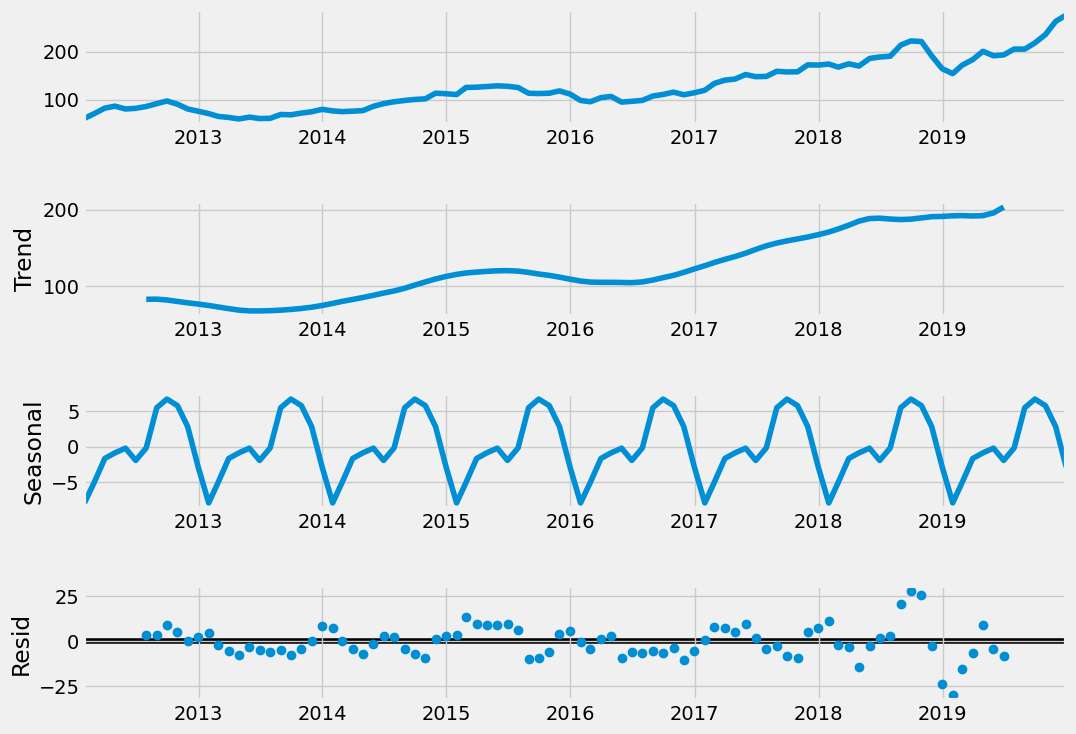

In [37]:
seas_add = seasonal_decompose(df_m, model='additive')
seas_add.plot()
plt.gcf().set_size_inches(12, 8);

### Repeating patterns are seen here. Seasonality refers to predictable changes that occur over a one-year period in a business or economy based on the seasons including calendar or commercial seasons. 

### Seasonal Subseries Plot :

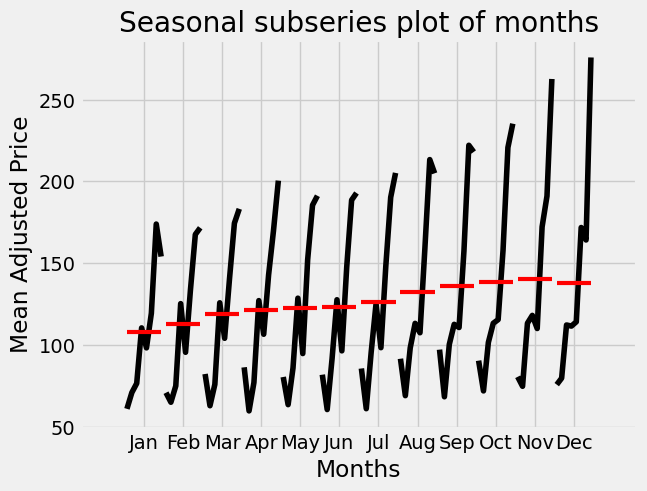

In [38]:
month_plot(df['Close'].resample('M').mean())
plt.title('Seasonal subseries plot of months')
plt.xlabel('Months')
plt.ylabel('Mean Adjusted Price')
plt.show() 

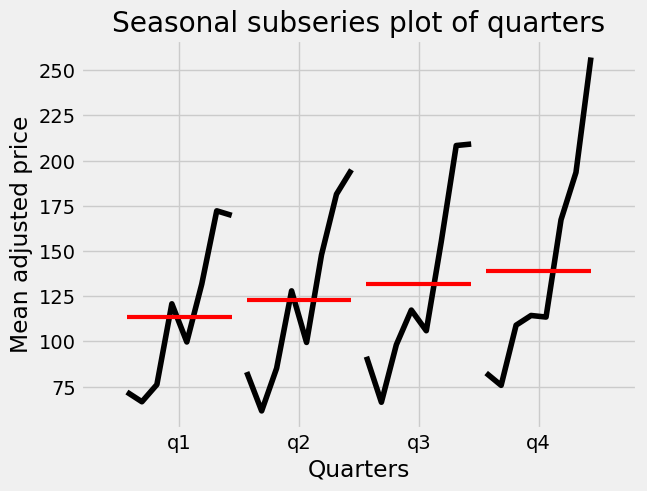

In [39]:
quarter_plot(df['Close'].resample('Q').mean())
plt.title('Seasonal subseries plot of quarters')
plt.xlabel('Quarters')
plt.ylabel('Mean adjusted price')
plt.show() 

### The quarter plot shows the seasonality more clearly than the month plot.

## Test for Stationarity :

### Rolling statistics:-

#### This method gave a visual representation of the data to define its stationarity. A Moving variance or moving average graph is plot and then it is observed whether it varies with time or not. In this method, a moving window of time is taken (here since the time series has holidays and totally 2011 records so taking approx. 252 days per year, 8 months is taken as window) and then the mean of that time period is calculated as the current value.



### Null Hypothesis - Time series has unit root, hence not stationary

### Alternate Hypothesis - Time series has no unit root, hence stationary

### If p-value is less than 0.05, reject Null Hypothesis

### If p-value is greater than 0.05, fail to reject Null Hypothesis

In [40]:
def test_stationarity(series):
    
    #Determine rolling statistics
    movingAverage = series.rolling(window=8).mean()
    movingSD = series.rolling(window=8).std()
    
    #Plot rolling statistics
    plt.plot(series, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #ad-fuller test
    stat_test = adfuller(series,autolag='AIC')
    print('Results of Dickey Fuller Test:')
    print()
    print('Test Statistic : ',stat_test[0])
    print('p value : ',stat_test[1])
    print('Number of Lags : ',stat_test[2])
    print('Critical values : ')
    for key, val in stat_test[4].items():
        print('\t',key, ': ',val)
    print()    
    if stat_test[1] > 0.05:
        print('Series is non-stationary')
    else:
        print('Series is stationary')

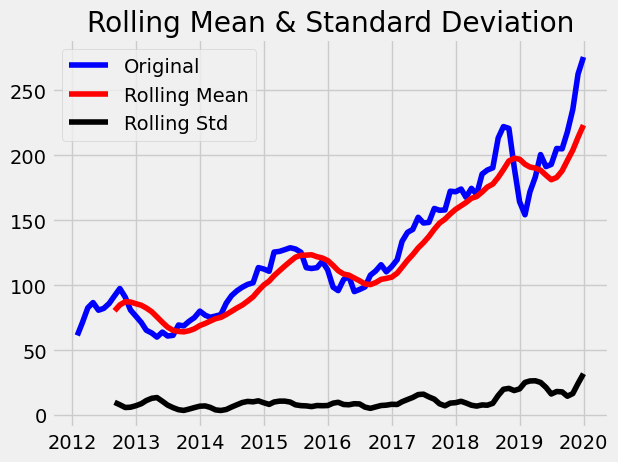

Results of Dickey Fuller Test:

Test Statistic :  0.5119654984597588
p value :  0.9852322761789652
Number of Lags :  1
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is non-stationary


In [41]:
test_stationarity(df_m)

### Observation :

#### The graph of rolling mean and standard deviation are not constant.

#### The p value is greater than 0.05 and the test statistic is more than the critical values. This suggests that we cannot reject the null hypothesis which means that the process has unit root, and the time series is non-stationary that has the time-dependent structure.

#### The series is non-stationary.

## Check the order of non-seasonal differencing needed using pmdarima and Differencing the time series :

In [42]:
diff = pm.arima.ndiffs(df_m['Close'],max_d=4)
print(f'Order of non-seasonal Differencing = {diff}')

Order of non-seasonal Differencing = 1


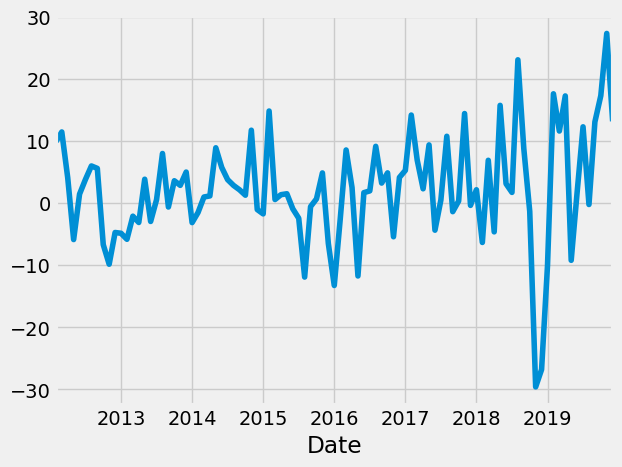

In [43]:
dfm_lag = df_m['Close'].rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag.plot(); 

In [44]:
diff1 = pm.arima.ndiffs(dfm_lag,max_d=4)
print(f'Order of non-seasonal Differencing = {diff1}') 

Order of non-seasonal Differencing = 0


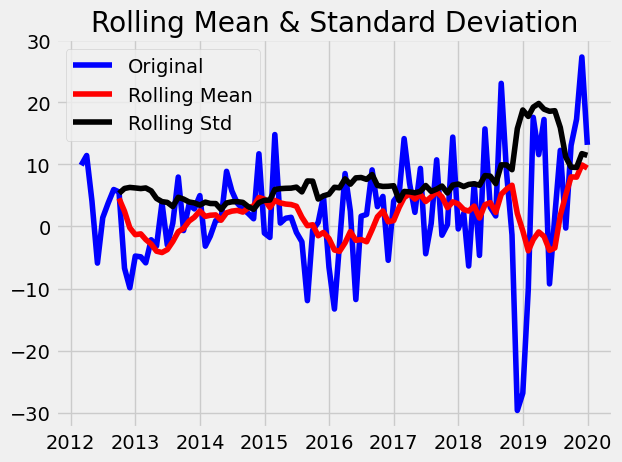

Results of Dickey Fuller Test:

Test Statistic :  -6.549178388231945
p value :  8.940119318440014e-09
Number of Lags :  0
Critical values : 
	 1% :  -3.5019123847798657
	 5% :  -2.892815255482889
	 10% :  -2.583453861475781

Series is stationary


In [45]:
test_stationarity(dfm_lag) 

### Observation :

#### The graph of rolling mean and standard deviation are constant.

#### The p value is very low and the test statistic is less than 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

#### Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

#### The series is trend stationary now.

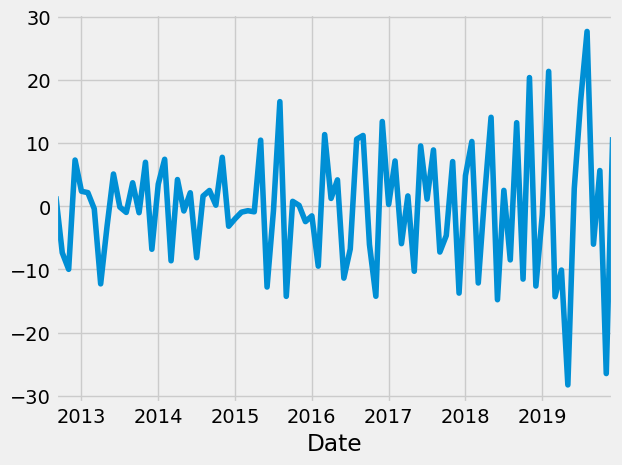

In [46]:
dfm_lag_se = dfm_lag.rolling(window=8).apply(lambda x: x.iloc[1] - x.iloc[0]).dropna()
dfm_lag_se.plot(); 

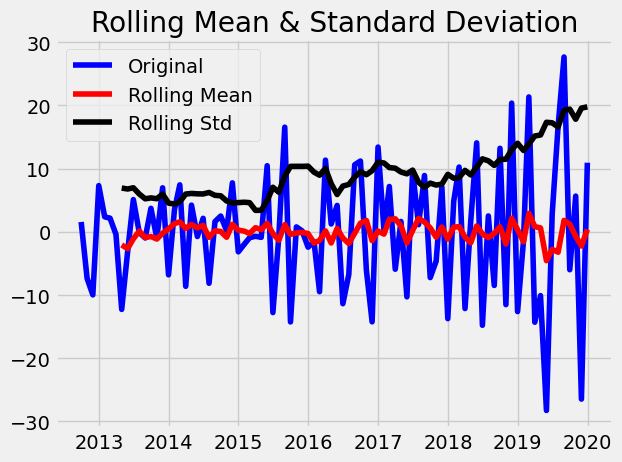

Results of Dickey Fuller Test:

Test Statistic :  -5.983007792223132
p value :  1.8196351010035204e-07
Number of Lags :  7
Critical values : 
	 1% :  -3.5148692050781247
	 5% :  -2.8984085156250003
	 10% :  -2.58643890625

Series is stationary


In [47]:
test_stationarity(dfm_lag_se) 

### Observation :

#### The graph of rolling mean and standard deviation are constant.

#### The p value is very low and the test statistic is less than 1% critical value. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

#### Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

#### The series is stationary now.

## ACF and PACF plots :

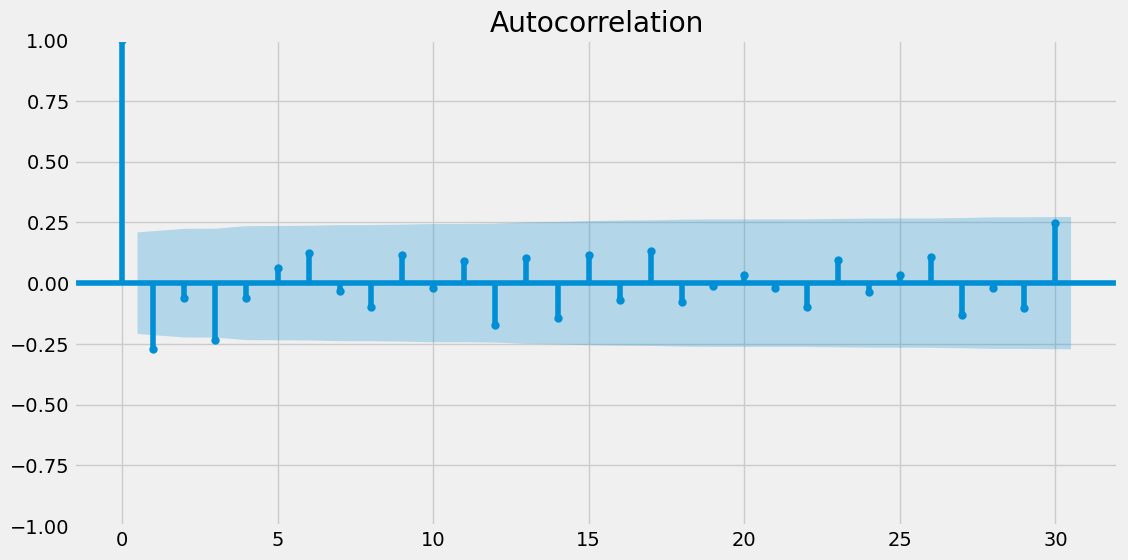

In [48]:
fig, ax = plt.subplots(figsize=(12,6))
acf = plot_acf(dfm_lag_se,lags=30,ax=ax) 

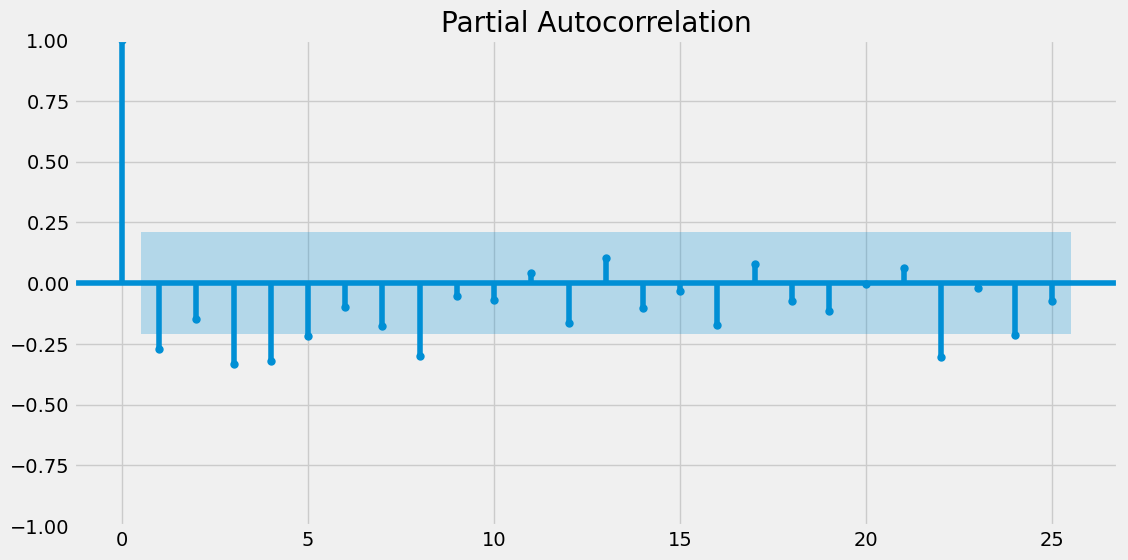

In [49]:
fig, ax = plt.subplots(figsize=(12,6))
pacf = plot_pacf(dfm_lag_se,lags=25,ax=ax)
 

### Observation :

#### In both ACF and PACF plots, the spike at one is significant so it is first order MA model from ACF, q=1 and first order AR model from PACF,p=1 --> ARMA(1,1).

#### Since the time series needed first order differencing to make it stationary, d=1. So ARIMA(1,1,1)

#### For the seasonality, other than initial spikes there is a spike at 8 in PACF plot, so order for AR, P=1. And there are no significant spikes on ACF plot other than initial ones, so MA order, Q=0. Since the time series had seasonality and we did first order seasonal differencing D=1

## Split data into train and test 

In [50]:
train = df.iloc[:len(df)-249]

# Taking last one year for testing
test = df.iloc[len(df)-249:]
test.head(),test.tail() 

(                 Close
 Date                  
 2019-01-02  157.919998
 2019-01-03  142.190002
 2019-01-04  148.259995
 2019-01-07  147.929993
 2019-01-08  150.750000,
                  Close
 Date                  
 2019-12-23  284.000000
 2019-12-24  284.269989
 2019-12-26  289.910004
 2019-12-27  289.799988
 2019-12-30  291.519989)

# ARIMA model :

In [51]:
model_1 = ARIMA(train,order=(1,1,1))
model_1 = model_1.fit()
model_1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1746
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3621.613
Date:                Mon, 10 Apr 2023   AIC                           7249.226
Time:                        14:18:05   BIC                           7265.619
Sample:                    01-03-2012   HQIC                          7255.287
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7990      0.094     -8.474      0.000      -0.984      -0.614
ma.L1          0.8391      0.087      9.652      0.000       0.669       1.009
sigma2         3.7171      0.063     58.780      0.000       3.593       3.841
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3267.45
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               3.41   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
start = len(train)
end = len(train)+len(test)-1
pred1 = model_1.predict(start=start,end=end,type='levels') 

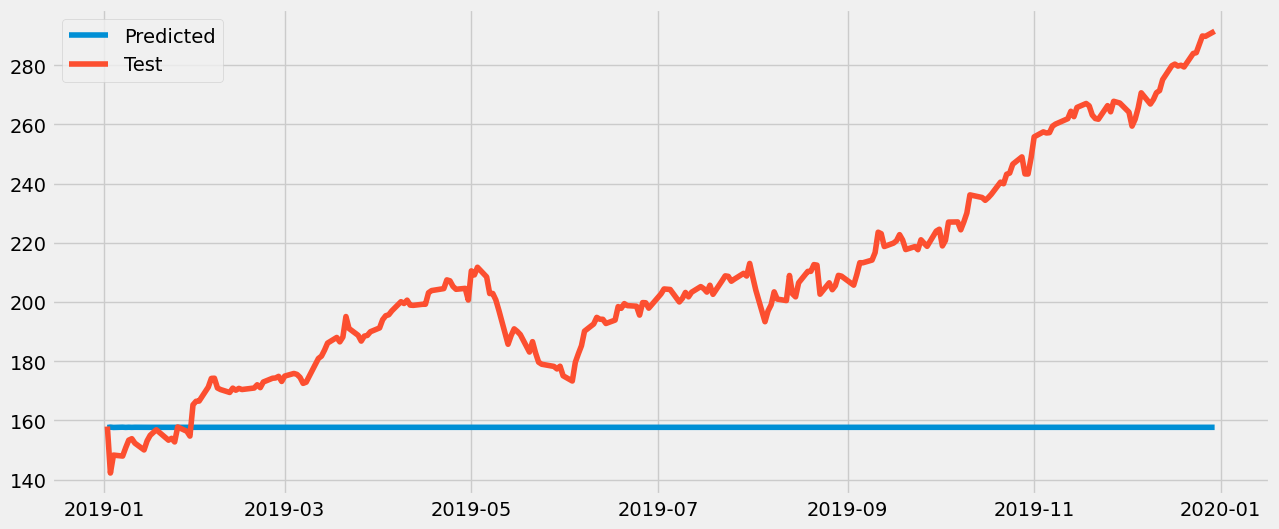

In [53]:
plt.figure(figsize=(14,6))
plt.plot(pred1, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show()
 

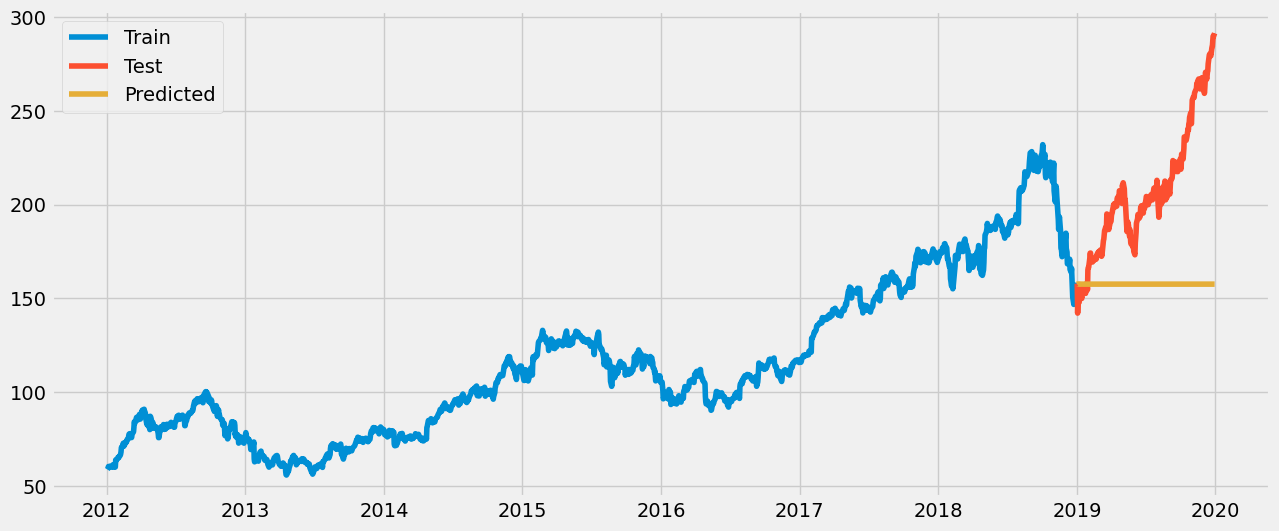

In [54]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred1, label='Predicted')
plt.legend(loc='best')
plt.show() 

### Arima model do not capture seasonality.

In [55]:
# Root Mean squared Error

rmse = sqrt(mean_squared_error(pred1,test))

print('Root Mean Squared Error of ARIMA model =',rmse) 

Root Mean Squared Error of ARIMA model = 60.42926800419543


In [56]:
test.mean() 

Close    207.585462
dtype: float64

## SARIMA with Quarterly Seasonality :

In [57]:
model_sr = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,0,66))
model_sr = model_sr.fit()
model_sr.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               Close   No. Observations:                 1746
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 66)   Log Likelihood               -3804.805
Date:                             Mon, 10 Apr 2023   AIC                           7617.611
Time:                                     14:18:34   BIC                           7639.315
Sample:                                 01-03-2012   HQIC                          7625.651
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2085      0.231     -0.903      0.367      -0.661       0.244
ma.L1          0.2773      0.230      1.205      0.228      -0.174       0.728
ar.S.L66      -0.5284      0.018    -29.576      0.000      -0.563      -0.493
sigma2         5.3736      0.098     54.730      0.000       5.181       5.566
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1962.44
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.50
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
pred4 = model_sr.predict(start=start,end=end) 

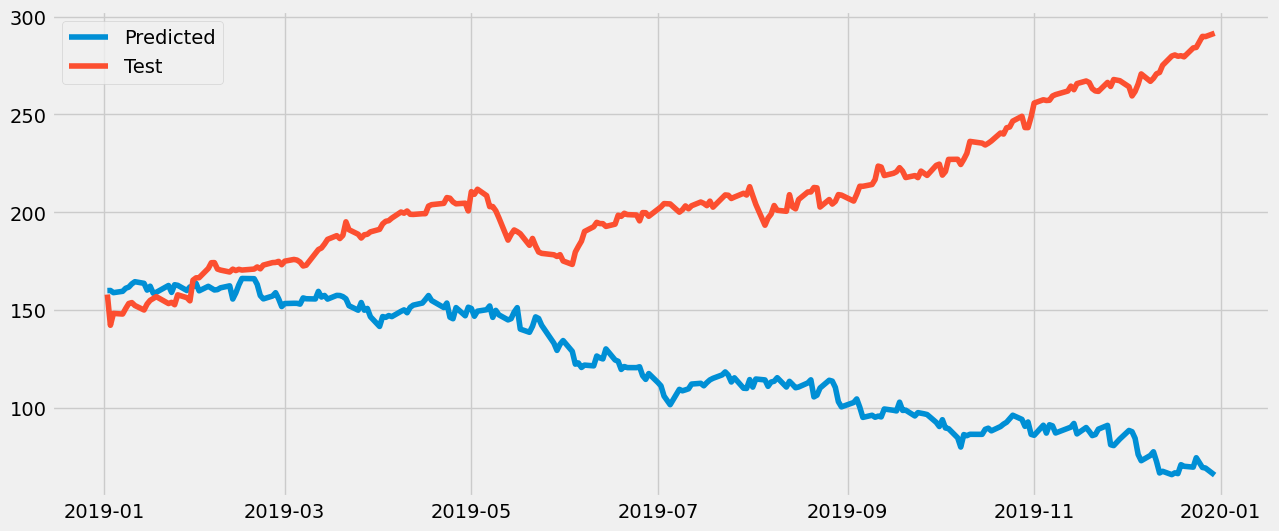

In [59]:
plt.figure(figsize=(14,6))
plt.plot(pred4, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show() 

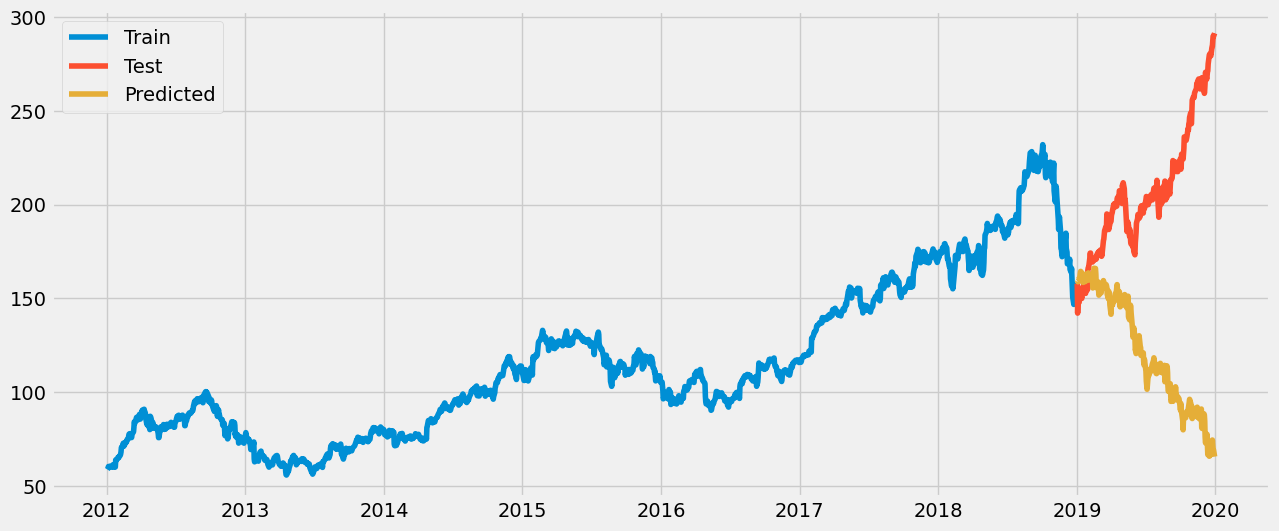

In [60]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred4, label='Predicted')
plt.legend(loc='best')
plt.show()
 

In [61]:
# Root Mean Squared Error
rmse4 = sqrt(mean_squared_error(pred4,test))

print('Root Mean Squared Error of SARIMA with Quarterly Seasonality =',rmse4)

Root Mean Squared Error of SARIMA with Quarterly Seasonality = 105.74670694022598


## ARIMA with Seasonal order using Maximum likelihood estimation :

In [62]:
model_se = sm.tsa.arima.ARIMA(train,order=(1,1,1),seasonal_order=(1,1,0,251))
result = model_se.fit(method='innovations_mle',low_memory=True,cov_type='none') 

In [63]:
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1746
Model:             ARIMA(1, 1, 1)x(1, 1, [], 251)   Log Likelihood               -3384.443
Date:                            Mon, 10 Apr 2023   AIC                           6776.885
Time:                                    14:20:34   BIC                           6798.122
Sample:                                01-03-2012   HQIC                          6784.798
                                     - 12-31-2018                                         
Covariance Type:                     Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8199        nan        nan        nan         nan         nan
ma.L1          0.8440        nan        nan        nan         nan         nan
ar.S.L251     -0.3962        nan        nan        nan         nan         nan
sigma2         5.2812        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               902.55
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               2.98   Skew:                            -0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [64]:
pred2 = result.predict(start=start,end=end,type='levels') 

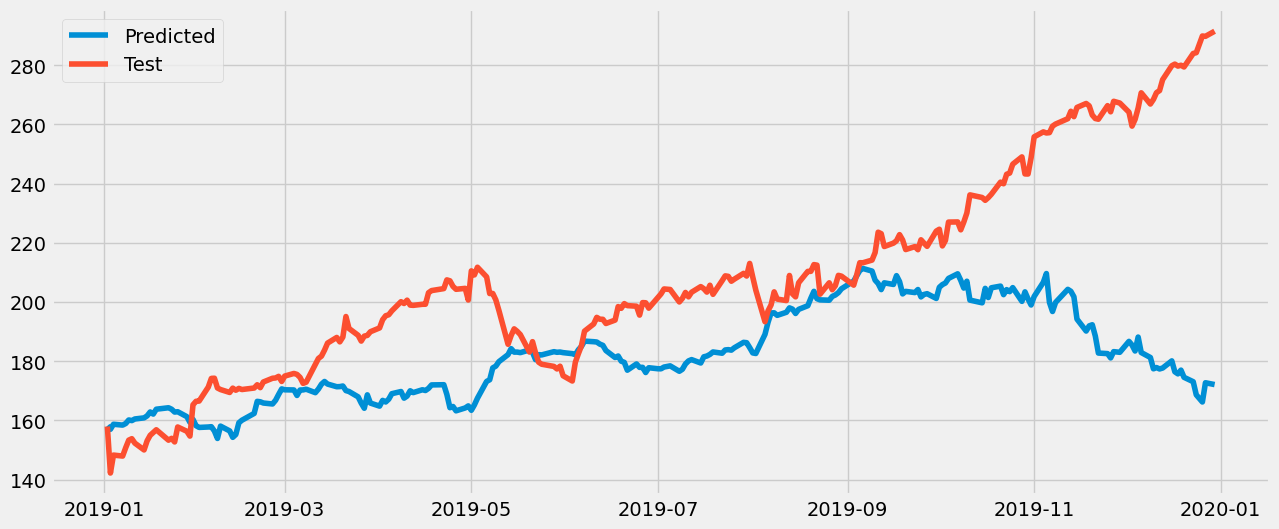

In [65]:
plt.figure(figsize=(14,6))
plt.plot(pred2, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show() 

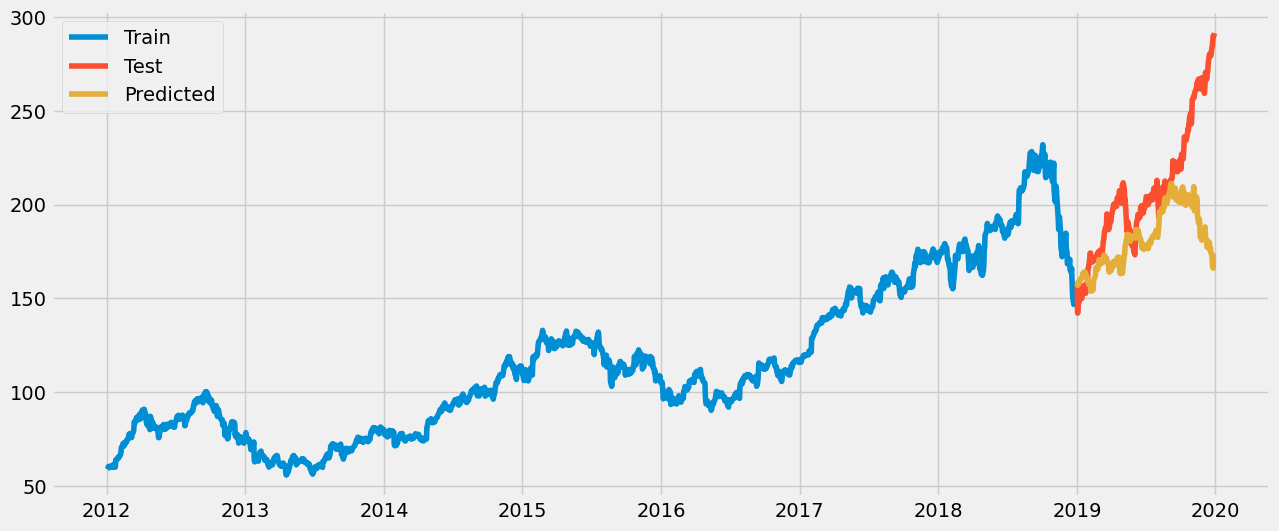

In [66]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred2, label='Predicted')
plt.legend(loc='best')
plt.show() 

In [67]:
# Root Mean squared Error
rmse2 = sqrt(mean_squared_error(pred2,test))

print('Root Mean Squared Error of ARIMA with seasonal order using innovations_mle method =',rmse2) 

Root Mean Squared Error of ARIMA with seasonal order using innovations_mle method = 38.848230164811994


### This model has captured seasonality and the rmse is low compared to non-seasonal arima and sarima models.

## Holt-Winters Triple Exponential Smoothing :

In [68]:
model_h = ExponentialSmoothing(train,trend='mul',seasonal='mul',seasonal_periods=252)
model_h = model_h.fit()
model_h.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    Close   No. Observations:                 1746
Model:             ExponentialSmoothing   SSE                           5518.217
Optimized:                         True   AIC                           2521.170
Trend:                   Multiplicative   BIC                           3920.231
Seasonal:                Multiplicative   AICC                          2611.045
Seasonal Periods:                   252   Date:                 Mon, 10 Apr 2023
Box-Cox:                          False   Time:                         14:20:46
Box-Cox Coeff.:                    None                                         
==================================================================================
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.9950038                alpha                 True
smoothing_trend                0.0001001                 beta                 True
smoothing_seasonal             0.0049923                gamma                 True
initial_level                  82.121099                  l.0                 True
initial_trend                  1.0001709                  b.0                 True
initial_seasons.0              0.9664149                  s.0                 True
initial_seasons.1              0.9638897                  s.1                 True
initial_seasons.2              0.9720774                  s.2                 True
initial_seasons.3              0.9848875                  s.3                 True
initial_seasons.4              0.9838433                  s.4                 True
initial_seasons.5              0.9875422                  s.5                 True
initial_seasons.6              0.9848421                  s.6                 True
initial_seasons.7              0.9718617                  s.7                 True
initial_seasons.8              0.9743251                  s.8                 True
initial_seasons.9              0.9940891                  s.9                 True
initial_seasons.10             0.9938963                 s.10                 True
initial_seasons.11             0.9713473                 s.11                 True
initial_seasons.12             0.9749649                 s.12                 True
initial_seasons.13             0.9860181                 s.13                 True
initial_seasons.14             0.9928348                 s.14                 True
initial_seasons.15             1.0009798                 s.15                 True
initial_seasons.16             1.0116840                 s.16                 True
initial_seasons.17             1.0138536                 s.17                 True
initial_seasons.18             1.0164563                 s.18                 True
initial_seasons.19             1.0262080                 s.19                 True
initial_seasons.20             1.0354994                 s.20                 True
initial_seasons.21             1.0435095                 s.21                 True
initial_seasons.22             1.0528813                 s.22                 True
initial_seasons.23             1.0554756                 s.23                 True
initial_seasons.24             1.0510636                 s.24                 True
initial_seasons.25             1.0493165                 s.25                 True
initial_seasons.26             1.0583524                 s.26                 True
initial_seasons.27             1.0614376                 s.27                 True
initial_seasons.28             1.0544181                 s.28                 True
initial_seasons.29             1.0591690                 s.29          

In [69]:
pred3 = model_h.predict(start=start,end=end)

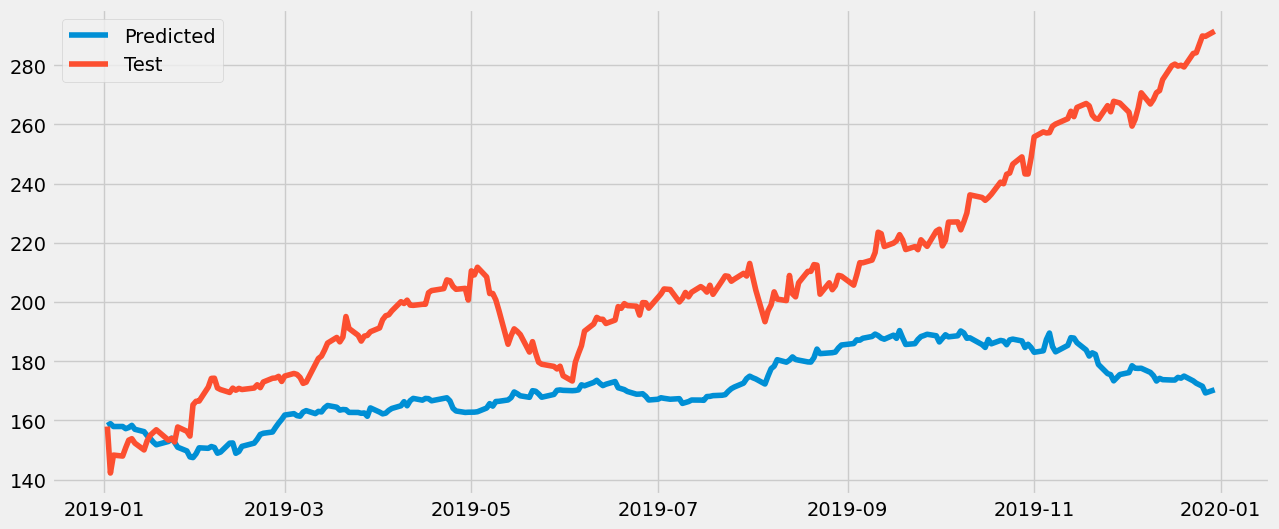

In [70]:
plt.figure(figsize=(14,6))
plt.plot(pred3, label='Predicted')
plt.plot(test, label='Test')
plt.legend(loc='best')
plt.show() 

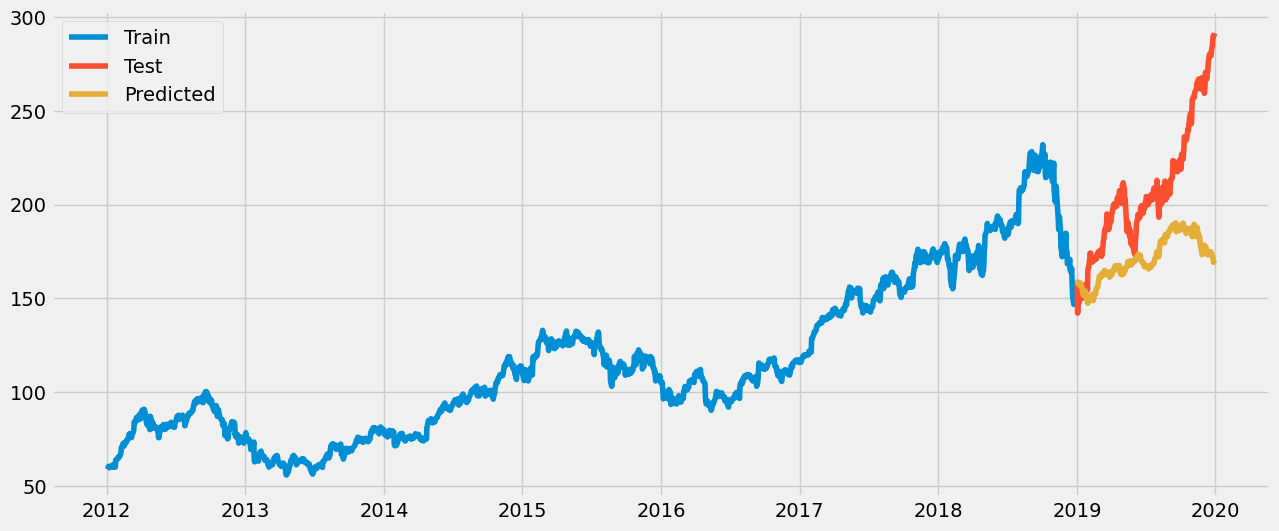

In [71]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred3, label='Predicted')
plt.legend(loc='best')
plt.show() 

In [72]:
# Root Mean Squared Error
rmse3 = sqrt(mean_squared_error(pred3,test))

print('Root Mean Squared Error of Holt Winters Triple Exponential Smoothing =',rmse3)

Root Mean Squared Error of Holt Winters Triple Exponential Smoothing = 45.625368670005344


### Summarizing :

In [73]:
data1 = {'Models':['ARIMA','ARIMA with Seanonal oder','SARIMA with Quaterly Seasonality',
                   'Holt-Winters Triple Exponential Smoothing with Multiplicative Seasonality',
                   ],
       'Root Mean Squared Error':[rmse,rmse2,rmse4,rmse3]}
Model = pd.DataFrame(data1)
Model = Model.sort_values('Root Mean Squared Error').reset_index(drop=True)
Model 

Models  Root Mean Squared Error
0                           ARIMA with Seanonal oder                38.848230
1  Holt-Winters Triple Exponential Smoothing with...                45.625369
2                                              ARIMA                60.429268
3                   SARIMA with Quaterly Seasonality               105.746707

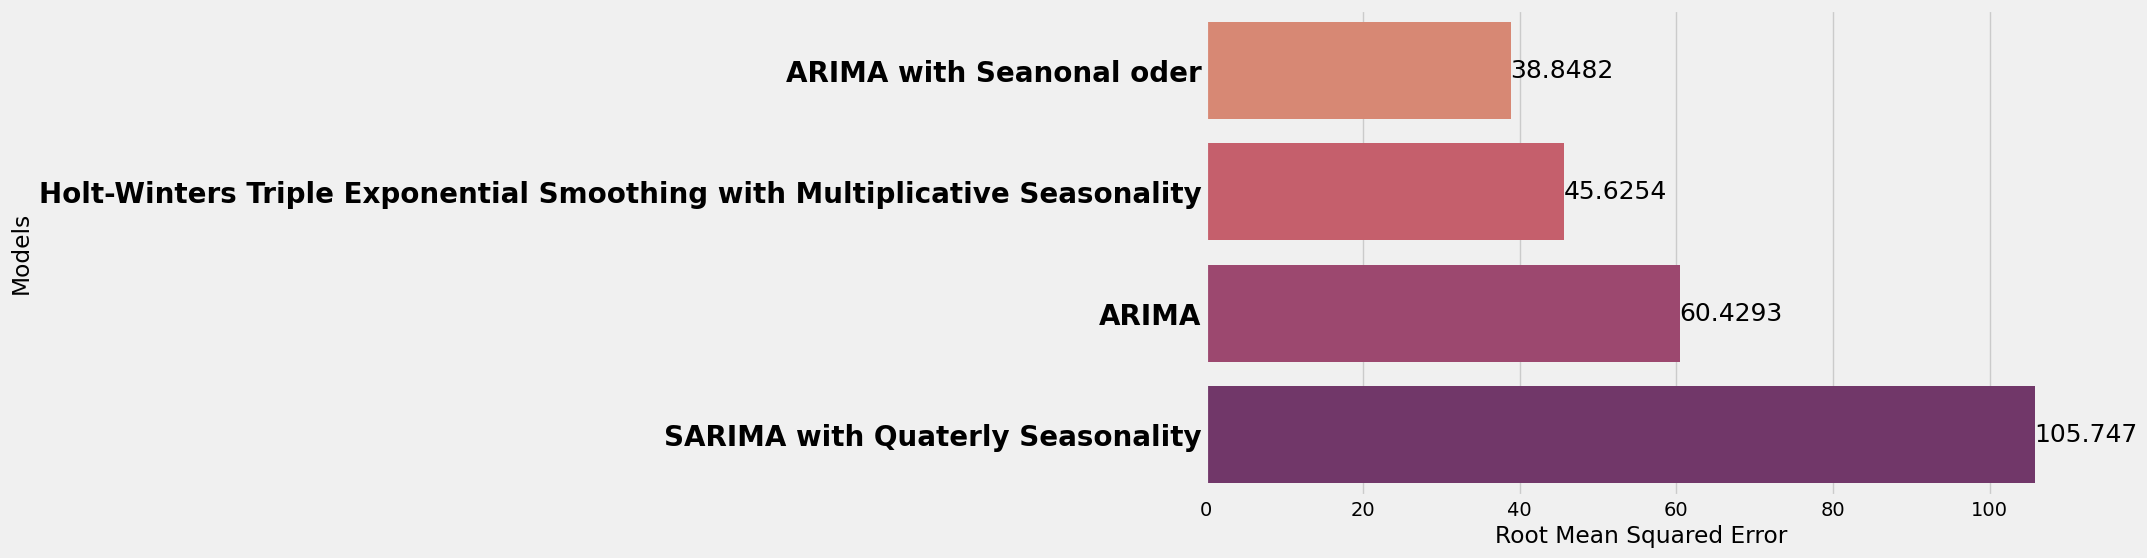

In [74]:
plt.figure(figsize=(10,6))
ax = sns.barplot(data=Model,x='Root Mean Squared Error',y='Models',palette='flare',ci=None)
plt.yticks(fontsize=20,fontweight='bold');
for i in ax.containers:
    ax.bar_label(i,fontsize=18)

### As the exponential smoothing methods predict future patterns to heavily represent current ones they are less effective in long term forecasting. So selecting Arima with Seasonal order and Sarima with Quaterly seasonality as the best models for forecasting.

### As Sarima with Quaterly Seasonality looks computationally heavy, using Arima with seasonal order for the forecasting.

### Training the best model on the whole dataset to forecast :
### Arima with Seasonal order :

In [75]:
model_se1 = sm.tsa.arima.ARIMA(df,order=(1,1,1),seasonal_order=(1,1,0,251))
model_se1 = model_se1.fit(method='innovations_mle',low_memory=True,cov_type='none')
model_se1.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 1995
Model:             ARIMA(1, 1, 1)x(1, 1, [], 251)   Log Likelihood               -4153.280
Date:                            Mon, 10 Apr 2023   AIC                           8314.560
Time:                                    14:22:14   BIC                           8336.413
Sample:                                01-03-2012   HQIC                          8322.640
                                     - 12-30-2019                                         
Covariance Type:                     Not computed                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8387        nan        nan        nan         nan         nan
ma.L1          0.8604        nan        nan        nan         nan         nan
ar.S.L251     -0.5440        nan        nan        nan         nan         nan
sigma2         6.5356        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1510.47
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               3.91   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.52
===================================================================================

Warnings:
[1] Covariance matrix not calculated.
"""

In [76]:
## Forecast for next 30 days :

In [77]:
f = pd.DataFrame(model_se1.forecast(30))
f

predicted_mean
2019-12-31      289.376363
2020-01-02      289.883962
2020-01-03      290.392610
2020-01-06      282.074556
2020-01-07      286.607166
2020-01-08      286.342771
2020-01-09      288.145745
2020-01-10      290.316144
2020-01-13      290.243557
2020-01-14      289.495831
2020-01-15      288.470315
2020-01-16      290.374848
2020-01-17      292.240681
2020-01-21      292.146724
2020-01-22      294.187556
2020-01-23      292.652667
2020-01-24      292.514279
2020-01-27      291.151901
2020-01-28      293.490930
2020-01-29      291.282790
2020-01-30      288.859195
2020-01-31      293.890881
2020-02-03      292.507235
2020-02-04      292.001043
2020-02-05      294.411609
2020-02-06      295.935200
2020-02-07      292.004678
2020-02-10      288.316407
2020-02-11      291.634183
2020-02-12      289.287307

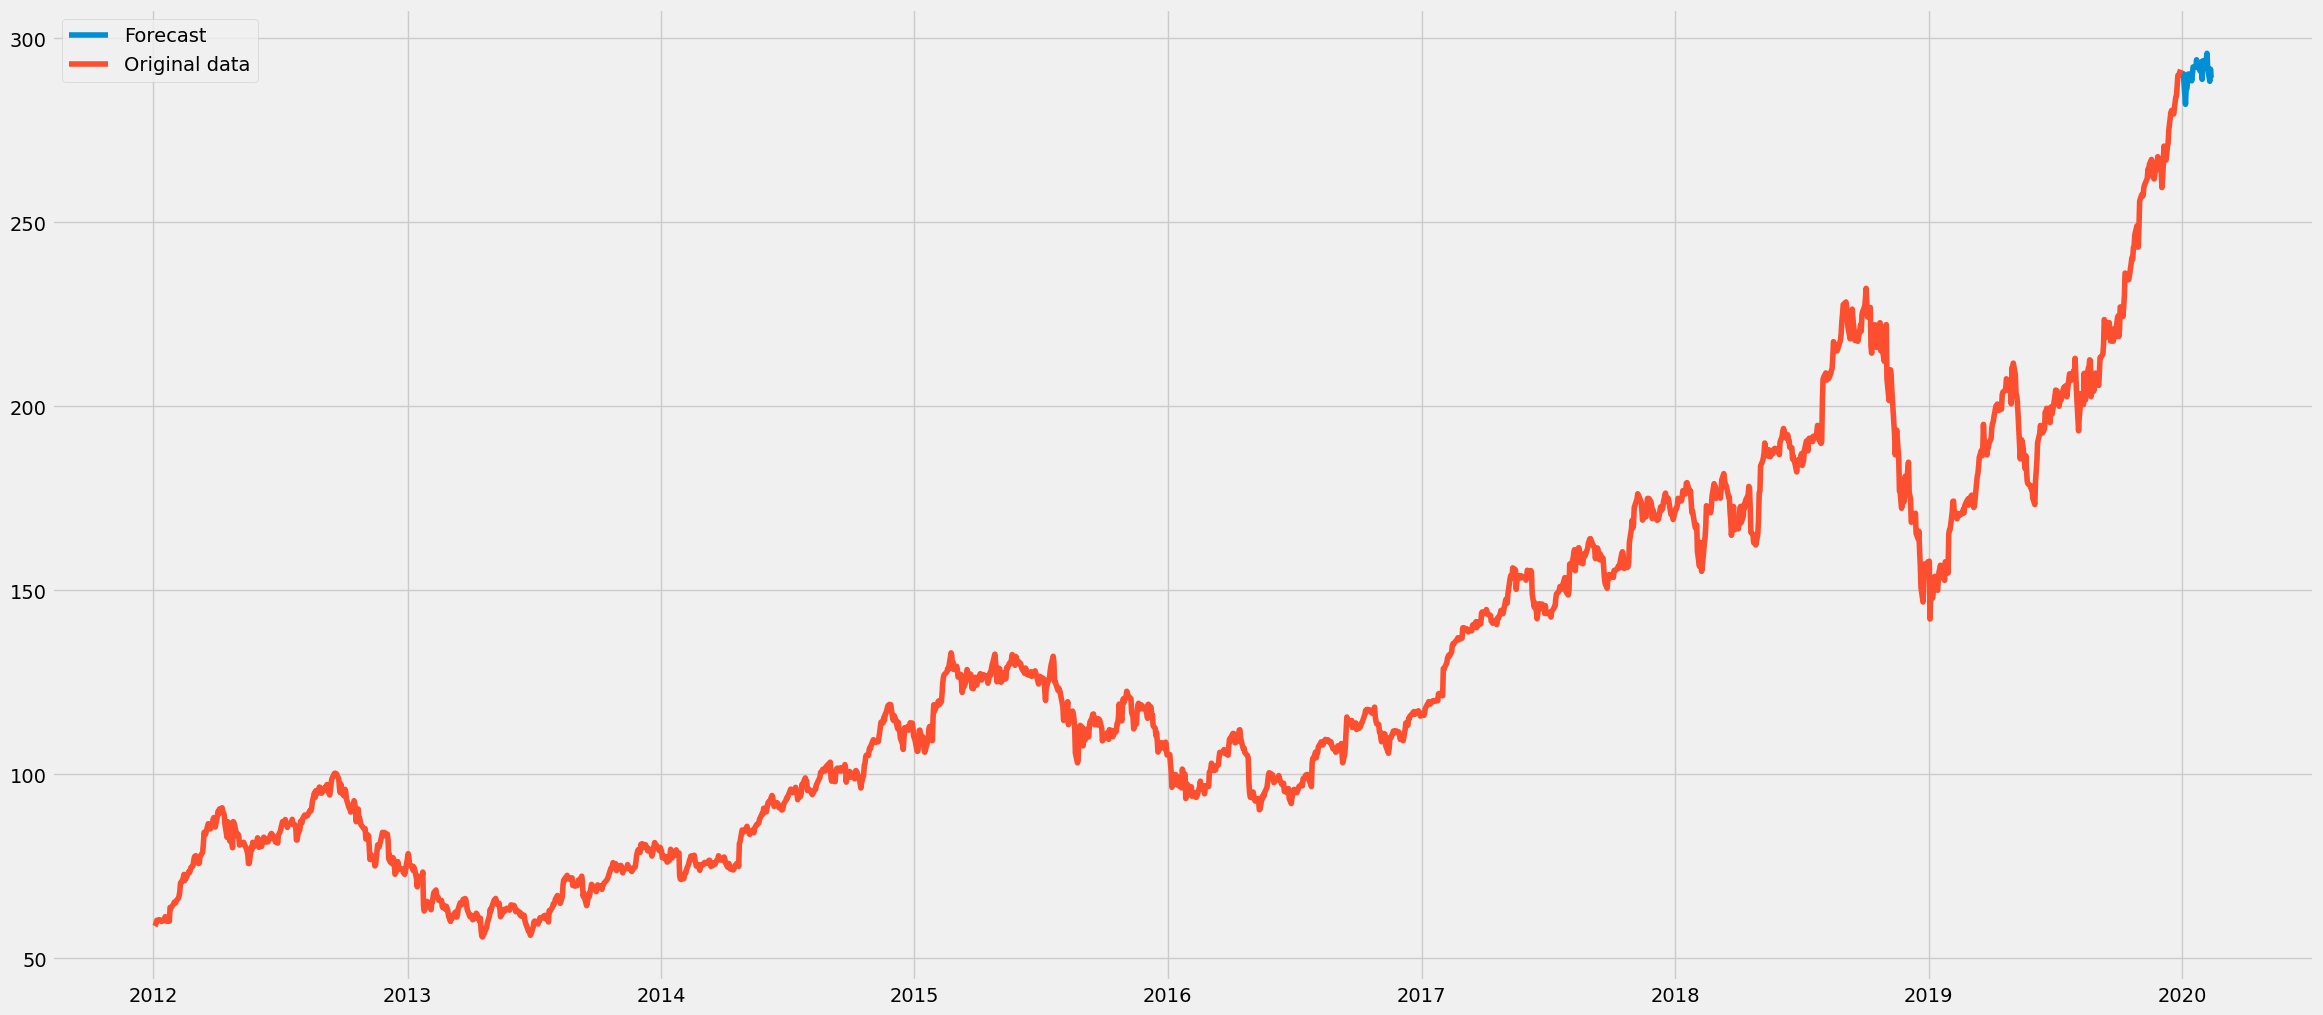

In [78]:
plt.figure(figsize=(26,12))
plt.plot(f, label='Forecast')
plt.plot(df, label='Original data')
plt.legend(loc='best')
plt.show()

## Deployment

In [2]:
!pip install dump

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for dump: filename=dump-0.0.5-py3-none-any.whl size=9001 sha256=dba7ab5f5608d1f804cedcd24f95b6442cea40f7fe5518cbd864cd8bebb7cfa6
  Stored in directory: c:\users\padmakar\appdata\local\pip\cache\wheels\6b\95\62\0507d7240adbdf04003bfde5d4009b6f6ba9afcc2e8b5c42a1
Successfully built dump


In [80]:
import pickle

In [81]:
filename ='model_trained.pkl'

In [79]:
pickle.dump(model_se1,open(filename,'wb'))